# Unsupervised Learning and Autoencoders

So far in these notes, we have focused almost exclusively on *supervised* learning. In this setting, we had a predictor matrix $\mathbf{X} \in \mathbb{R}^{n \times p}$ and a target vector $\mathbf{y} \in \mathbb{R}^n$. Our general goal was to learn patterns that would allow us to make predictions: given a new set of predictors $\mathbf{x}$, we could compute a prediction $\hat{y}$ that is hopefully "close" in some sense to the true label $y$. As we saw, this supervised framework encompasses both classification and regression problems. 

But what happens when there are no targets $\mathbf{y}$? Is it still possible to learn some interesting patterns in our data? Yes! *Unsupervised learning* is the name for the broad class of machine learning problems that ask us to "find some patterns in the data" without necessarily using a target variable to evaluate whether these patterns are "right" or "accurate."

## Autoencoders

There are *many* kinds of unsupervised learning, and there is no single unifying framework that can capture all of them. For the purposes of these notes, we are going to focus on a particular paradigm for unsupervised learning that captures several important and useful examples. This is the framework of *encoders* and *decoders*.  

Let $\mathbf{X} \in \mathbb{R}^{n\times p}$ be our matrix of data. An *encoder* is a function $\phi_e: \mathbf{x} \mapsto c_\mathbf{x}$, which associates to each data point $\mathbf{x}$ a *code* $c_{\mathbf{x}}$. This code is intended to contain some compressed information that could, in principle, be used to approximately reconstruct the data point. A *decoder* is a function which does the reconstruction: the decoder function $\psi_d c_\mathbf{x} \mapsto \hat{\mathbf{x}} \in \mathbb{R}^n$ sends the code $c_\mathbf{x}$ to a "reconstructed" vector $\hat{\mathbf{x}}$. [I have added a subscript $e$ to the encoder $\phi_e$ just to remind us that it is the encoder, and similarly a subscript $d$ to $\psi_d$. These subscripts are mnemonic devices that don't have any further mathematical significance.]{.aside} We aim for an encoder-decoder pair that "successfully" approximates the original data points, where "successful" depends on the purpose of our unsupervised learning application as well as various modeling choices. 

In order to define the idea of the reconstructed data point $\hat{\mathbf{x}}$ being close to the *true* data point $\mathbf{x}$, we need to again define a *loss function* to measure closeness. Following our notation from supervised learning, we'll denote the per-observation loss $\ell: \mathbb{R}^n \times \mathbb{R}^n \rightarrow \mathbb{R}$. Note that, unlike in the supervized learning case, $\ell$ is a function of pairs of vectors rather than pairs of scalars representing elements of the target vector. 

So, given a data set, an encoder, a decoder, and a loss function, we can define the *reconstruction loss* of the encoder-decoder pair as 

$$
\DeclareMathOperator*{\argmin}{argmin}
\begin{aligned}
    \mathcal{L}(\phi_e, \psi_d) = \frac{1}{n} \sum_{i=1}^n \ell(\mathbf{x}_i, \psi_d(\phi_e(\mathbf{x}_i)))\;. 
\end{aligned}
$$

An *autoencoder* is an unsupervised machine learning model which simultaneously learns an encoder-decoder pair by minimizing a loss function. Our goal in the encoder-decoder framework is to find good choices of the encoder $\phi_e$ and the decoder $\psi_d$. 

We've intentionally been pretty vague about the nature of the code $c$. There are many ways in which we can define this code, all of which depend on what kind of patterns we are aiming to learn from our data. Here are a few examples: 

### Approximate the Data with Fewer Data Points: K-means

Suppose we are looking at data like this: 

In [1]:
#| code-fold: true
import torch 
import numpy as np
from matplotlib import pyplot as plt 
from sklearn.datasets import make_moons, make_circles, make_blobs
plt.style.use('seaborn-v0_8-whitegrid')

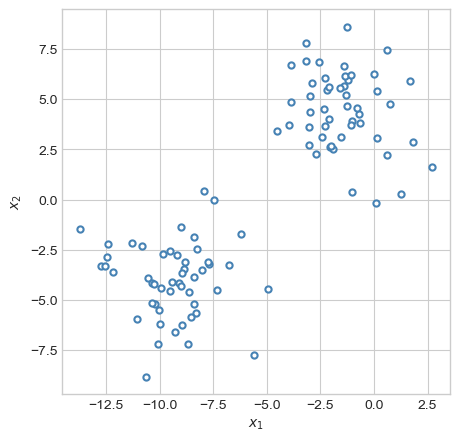

In [2]:
#| code-fold: true
X, y = make_blobs(n_samples=100, n_features=2, 
                                centers=2, random_state=1, cluster_std=2.0)

X, y = torch.tensor(X), torch.tensor(y)

def plot_2d_data(X, y, ax, **kwargs):
    if "edgecolor" not in kwargs:
        kwargs["edgecolor"] = "steelblue"
    ax.scatter(X[:,0].detach(), X[:,1].detach(), s = 20, facecolor = "white", linewidth = 1.5, **kwargs)    
    ax.set(xlabel = r"$x_1$", ylabel = r"$x_2$")

fig, ax = plt.subplots(1, 1, figsize=(5,5))
plot_2d_data(X, y, ax)

If asked to summarise this data in some way, you might reasonably suggest that the data is divided into two groups. If we wanted to know about an individual point, we could get a lot of information just by knowing which group it was in and where that group was located. 

To represent this logic, et's consider the following simple encoder-decoder pair. We'll pick a *number of centroids* $k < n$. Then, the encoder simply assigns an integer $h = 1,\ldots,k$ to each data point: 
$$
\begin{aligned}
    \phi_e(\mathbf{x}_i) = h_i\;.
\end{aligned}
$$

The *decoder* assigns to each integer $h = 1,\ldots,k$ a vector $\boldsymbol{\mu}_h \in \mathbb{R}^n$: $\psi_d(h) = \boldsymbol{\mu}_h$.  We can think of each $\boldsymbol{\mu}_h$, $h = 1,\ldots,k$, as a "representative" data point. We treat $\boldsymbol{\mu}_h$ as "representing" all of the data points $\mathbf{x}$ for which $\phi_e(\mathbf{x}) = h$. To measure the loss, we'll set $\ell$ to be the squared Euclidean distance: 

$$
\begin{aligned}
    \ell(\mathbf{x}_i, \boldsymbol{\mu}_h) = \|\mathbf{x}_i - \boldsymbol{\mu}_h\|^2\;.
\end{aligned}
$$

The objective function for our encoder-decoder problem is then 
$$
\begin{aligned}
    \mathcal{L}(\phi_e, \psi_d) &= \frac{1}{n} \sum_{i=1}^n \|\mathbf{x}_i - \psi_d(\phi_e(\mathbf{x}_i))\|^2 \\ 
    &= \frac{1}{n} \sum_{i=1}^n \|\mathbf{x}_i - \boldsymbol{\mu}_{\phi_e(\mathbf{x}_i)}\|^2 \\ 
    &= \frac{1}{n} \sum_{i=1}^n \|\mathbf{x}_i - \boldsymbol{\mu}_{h_i}\|^2\;.
\end{aligned}
$$

This last expression is the objective function for the well-known *k-means clustering problem*. We have arrived at this algorithm through the somewhat unusual route of encoder-decoder pairs. 

In the k-means algorithm, we aim to optimize both the centroids $\boldsymbol{\mu}_h$, $h = 1,\ldots,k$, and the assignments $h_i$, $i = 1,\ldots,n$. Unfortunately, although optimizing the *centroids* is a convex problem, optimizing the *assignments* is not. Worse yet, since the assignments are discrete, we can't do gradient descent either! The k-means clustering problem is typically solved using a heuristic algorithm with very fast performance: 

Until converged: 

1. For each data index $i$, let $h_i \gets \argmin_{h} \|\mathbf{x}_i - \boldsymbol{\mu}_h  \|^2$ be the index of the closest centroid $\boldsymbol{\mu_{h}}$ to $\mathbf{x}_i$.
2. Then, for each centroid index $h$, let $\boldsymbol{\mu}_h$ be the mean of all the data points $\mathbf{x}_i$ for which $h_i = h$:
$$
\begin{aligned}
    \boldsymbol{\mu}_h \gets \frac{\sum_{i=1}^n \mathbf{x}_i \mathbb{1}[h_i = h]}{\sum_{i=1}^n \mathbb{1}[h_i = h]}\;.
\end{aligned}
$$


::: {.callout-note}
::: {#thm-kmeans-works}

## K-Means Clustering Works

Provided that every cluster centroid is always associated to at least one point: 

1. Each of the two phases of the k-means algorithm is guaranteed not to increase the objective function $\mathcal{L}(\phi_e, \psi_d)$.
2. The k-means algorithm is guaranteed to terminate in a finite number of steps. 
3. At termination, k-means will return an encoder and decoder which are local optima of $\mathcal{L}(\phi_e, \psi_d)$. 

:::
:::

Here is an implementation of the k-means clustering algorithm. In the case of k-means, it is not too beneficial from an implementation perspective to explicitly represent the encoder and decoder as part of the code. This is because we can't directly perform optimization on the encoder and decoder (due to the nondifferentiability of the encoder). Instead, we'll use a direct implementation. 

In [3]:
# implement the k-means step
# M is a matrix of centroids
# z is a vector of labels
def k_means_step(X, M, z):

    # Step 1 of k-means: assign each point to the closest centroid
    D = torch.cdist(X, M) # distances between points and centroids
    z = torch.argmin(D, dim = 1)   # each point's new centroid is the closest one

    # Step 2 of k-means: update the centroids
    # each centroid's new value is the mean of all the points in its group
    for j in range(M.shape[0]):
        
        ix = z == j 
        # if a centroid has any points assigned to it, update it
        if ix.sum() > 0:
            M[j,:] = X[ix].mean(dim = 0)
        
        # otherwise, reinitialize the centroid with random numbers
        else:
            M[j,:] = torch.rand(M[j,:].shape, dtype = torch.float64)
        
    return M, z

# main loop for k-means
def k_means(X, k = 2):

    # initialization
    n, p = X.size()
    M = torch.rand(k, p, dtype = torch.float64) # initialize matrix of clusters
    z_prev = torch.randint(k, (k, n)) # assignments of points to clusters
    done = False

    # main loop: take a step until labels stop updating
    while not done: 
        M, z   = k_means_step(X, M, z_prev)
        done   = torch.all(z_prev == z)
        z_prev = z
    
    # return centroid matrix and cluster labels
    return M, z

Let's go ahead and run this algorithm: 

In [4]:
#---
M, z = k_means(X, 2)
#---

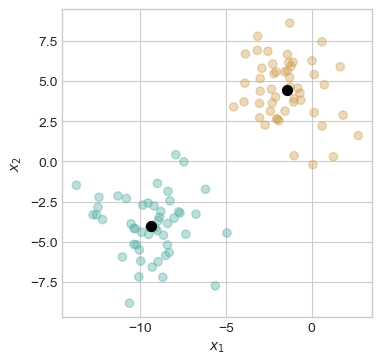

In [5]:
fig, ax = plt.subplots(1, figsize = (4, 4))
a = ax.scatter(X[:, 0], X[:, 1], c = z, alpha = 0.4, cmap = plt.cm.BrBG, vmin = -0.5, vmax = 1.5)
a = ax.set(xlabel = r"$x_1$", ylabel = r"$x_2$")

ax.scatter(M[:,0], M[:,1], s = 50, color = "black")

The two centroids are shown as black dots. The colors of the points indicate the centroid to which those points are assigned by the k-means clustering algorithm. 

A few practical notes: 

1. Since k-means is a nonconvex optimization problem, the final results will in general depend on the initial random choice of centroids. For this reason, it is often best to run k-means multiple times and choose the result with the lowest value of the objective function. Many very fast implementations of k-means exist, which means that running it multiple times is usually fairly practical. 
2. How many clusters should we use? This question is usually addressed by running k-means with many different values of $k$ and inspecting a plot of the loss function. You can learn more details about this method [here](https://en.wikipedia.org/wiki/Elbow_method_(clustering)). 

## Approximate the Data With Fewer Features: Linear Autoencoders

Let's now suppose that, instead of approximating many data points with a smaller number of representative points, we instead want to approximate the many data *features* with a smaller number of representative features. Despite the apparent parallel to the problem above, this one is quite different. There are many approaches to this kind of problem, and we'll focus on only one in these notes. 

### Linear Encoders, Linear Decoders

Let's again use the encoder-decoder framework from above. This time, the function $\phi_e$ is going to be a *linear* function: 

$$
\begin{aligned}
    \phi_e(\mathbf{x}) =  \mathbf{x}\mathbf{U}\;. 
\end{aligned}
$$

Here, $\mathbf{U} \in \mathbb{R}^{p \times k}$ is a matrix with $k < p$ rows. 

Similarly, the decoder function $\psi_d$ will also be linear:

$$
\begin{aligned}
    \psi_d(\mathbf{c}) = \mathbf{c}\mathbf{V} \;.
\end{aligned}
$$

Here, the matrix $\mathbf{V} \in \mathbb{R}^{k \times p}$. 

Like last time, we'll use the squared Euclidean distance between the input and the reconstructed input as our loss function:

$$
\begin{aligned}
    \ell(\mathbf{x}, \hat{\mathbf{x}}) &= \|\mathbf{x} - \hat{\mathbf{x}}\|_2^2\ \\ 
    &=  \|\mathbf{x} - \mathbf{c} \mathbf{V} \|_2^2 \\ 
    &= \|\mathbf{x} - \mathbf{x}\mathbf{U} \mathbf{V} \|_2^2\;.
\end{aligned}
$$

The complete loss, summed across all observations, can be written 

$$
\begin{aligned}
    \mathcal{L}(\mathbf{U}, \mathbf{V}) &= \sum_{i=1}^n \|\mathbf{x}_i - \mathbf{x}_i\mathbf{U} \mathbf{V} \|_2^2 \\ 
    &\triangleq \|\mathbf{X} - \mathbf{X}\mathbf{U} \mathbf{V} \|_F^2\;.
\end{aligned}
$${#eq-le-loss}

Here, $\|\cdot\|_F$ is the Frobenius norm of a matrix, which is simply $\|\mathbf{A}\|_F = \sqrt{\sum_{i=1}^n \sum_{j=1}^p a_{ij}^2}$ for a matrix $\mathbf{A} \in \mathbb{R}^{n \times p}$.

Our problem of encoder-decoder learning is then simply to learn the matrices $\mathbf{U}$ and $\mathbf{V}$. We can code this up as a simple torch model: 

In [6]:
#---
import torch.nn as nn 

class LinearAutoEncoder(nn.Module):
    def __init__(self, input_dim, k):
        super().__init__()
        self.k = k
        self.encoder = nn.Linear(input_dim, self.k, dtype = torch.float64)
        self.decoder = nn.Linear(self.k, input_dim, dtype = torch.float64)
        
    def forward(self, x):
        return self.decoder(self.encoder(x))
    
    def loss(self, x):
        return torch.mean((self.forward(x) - x)**2)
#---

To illustrate, we'll work on the following data set: 

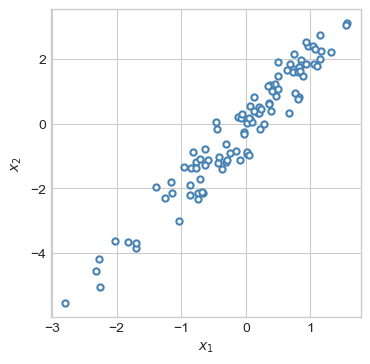

In [7]:
#| code-fold: true

n_points = 100
x = torch.randn(n_points, dtype = torch.float64)
X = torch.zeros(n_points, 2)
X[:, 0] = x 
X[:, 1] = 2*x + 0.5*torch.randn(n_points)
X = X.double()

fig, ax = plt.subplots(1, figsize = (4, 4))
plot_2d_data(X, torch.zeros(n_points), ax)

Now we'll instantiate and train our model. In this example, we'll assume that $k = 1$. 

In [8]:
le = LinearAutoEncoder(input_dim = 2, k = 1)

# standard training loop for models implemented in torch
#---
def train(X, model, lr = 0.1, n_iter = 1000):
    opt = torch.optim.Adam(model.parameters(), lr = lr)
    losses = []
    for i in range(n_iter):
        opt.zero_grad()
        loss = model.loss(X)
        losses.append(loss.item())
        loss.backward()
        opt.step()
    return losses

losses = train(X, le, lr = 0.1, n_iter = 10000)
#---

Now let's inspect the loss: 

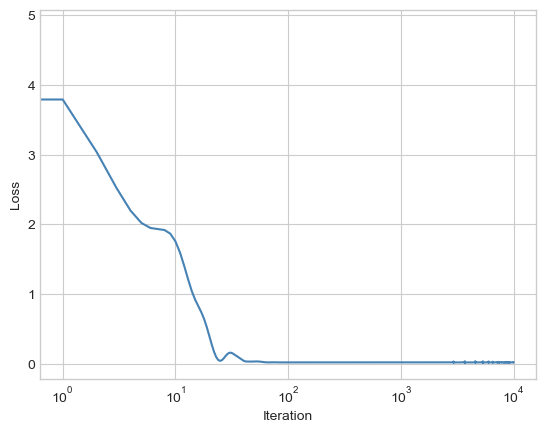

In [9]:
#| code-fold: true
plt.plot(losses, color = "steelblue")
plt.semilogx()
labs = plt.gca().set(xlabel = "Iteration", ylabel = "Loss")

The loss quickly converged. We can take a look at the trained reconstruction of the data just using the `forward` method: 

In [10]:
#---
X_hat = le.forward(X) # reconstructed data points
#---

Now we can compare the original and reconstructed data: 

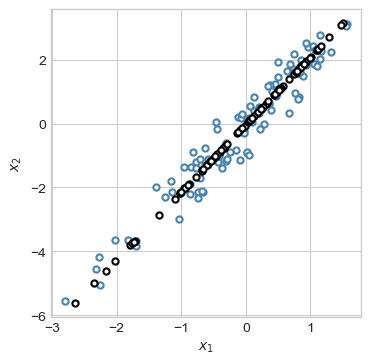

In [11]:
fig, ax = plt.subplots(1, figsize = (4, 4))
plot_2d_data(X, torch.zeros(n_points), ax)
plot_2d_data(X_hat, torch.zeros(n_points), ax, edgecolor="black")

Because we required that the learned linear encoding have rank 1, the  reconstruction is a 1-d subspace: a line. 

What would happen if we allowed the encoder to have rank 2? 

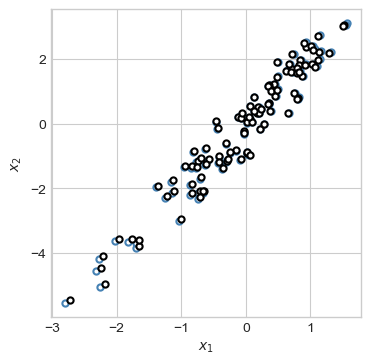

In [12]:
le = LinearAutoEncoder(input_dim = 2, k = 2)

losses = train(X, le, lr = 0.1, n_iter = 10000)

X_hat = le.forward(X)
fig, ax = plt.subplots(1, figsize = (4, 4))
plot_2d_data(X, torch.zeros(n_points), ax)

plot_2d_data(X_hat, torch.zeros(n_points), ax, edgecolor="black")

This experiment illustrates a very important general principle for learning with autoencoders: it is necessary for the encoder to map the data onto a space which is lower-dimensional than the domain of the original data itself. In this case, the encoder mapped the data from 2d space into 2d space, with the result that the autoencoder simply learned to memorize the data. It was only when we sent the 2d data into 1d feature space that the autoencoder was forced to learn more useful structure in the data. 

## Quick Example: Image Compression, Two Ways

One application of the encoder-decoder framework is *image compression*. In the image compression problem, we aim to represent an image using less information than the original. There are many ways to do image compression, and modern methods rely on very sophisticated algorithms. Here we'll focus only on illustrating our two simple methods. 

Let's use the following image of [Maru the cat](https://en.wikipedia.org/wiki/Maru_(cat)). 

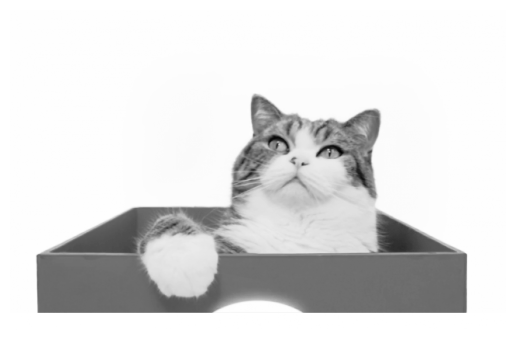

In [13]:
import urllib.request
from PIL import Image
from matplotlib import pyplot as plt
import torch
import numpy as np

def read_image(url):
    urllib.request.urlretrieve(url, "maru.png")
    img = Image.open("maru.png")
    return torch.tensor(np.array(img)/255).double()

url = "https://github.com/middlebury-csci-0451/CSCI-0451-s24/blob/main/assets/img/figs/maru.png?raw=true"

img = read_image(url)

def to_greyscale(im):
    v = torch.tensor([0.2989, 0.5870, 0.1140])
    return 1 - img[:,:,:3]@v.double()

img = to_greyscale(img)

def show(img):
    plt.imshow(img.detach(), cmap = "Greys")
    plt.axis("off")

show(img)

This image has size $413 \times 640$, which means that representing it exactly requires $413 \times 640 = 263,520$ floating point numbers to represent the greyscale values.

To apply $k$-means, we'll treat each individual pixel as a data point. This requires us to reshape the image. 

In [14]:
X = img.reshape(img.size(0)*img.size(1), 1)
X.size()

torch.Size([264320, 1])

Now we'll run k-means: 

In [15]:
M, z = k_means(X, 10)

And visualize the result! The code below reconstructs the image, replacing the value at each pixel with the corresponding centroid learned in k-means. 

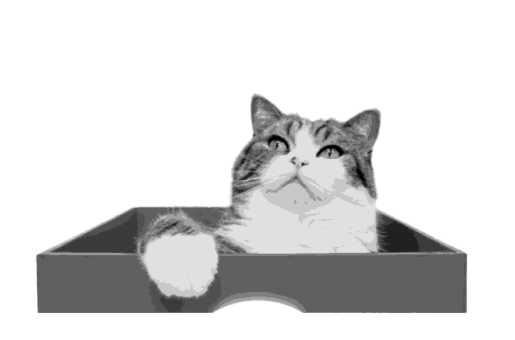

In [16]:
X_hat = M[z].reshape(img.size(0), img.size(1), 1)
show(X_hat)

The resulting image is clearly of lower quality, but just 10 distinct greyscale values are sufficient to make out the main features. The cost of storing this reconstruction is lower than storing the original image. Instead of needing to store a floating point greyscale value at each pixel, we can instead simply store the label of the centroid. This means we need to store $264320$ *integers*, and only $10$ floating point numbers. If we know that we do not need many clusters, the cost of storing integers can be considerably lower than the cost of storing floats. 

### Linear Autoencoder

What if instead we want to reduce the *dimension* of the image? In this case, we treat each row of the image as a piece of data, and we don't need to do any reshaping: 

In [17]:
le = LinearAutoEncoder(input_dim = img.size(1), k = 20)
losses = train(img, le, lr = 0.001, n_iter = 10000)

[]

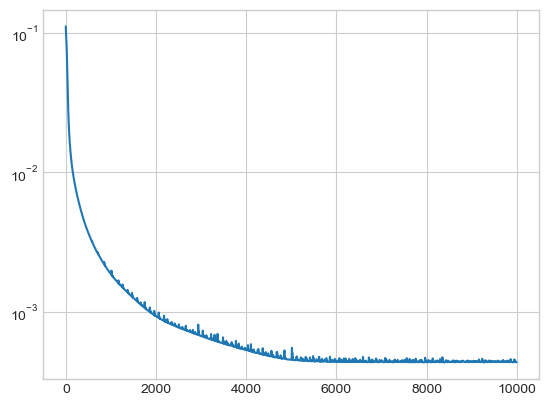

In [18]:
plt.plot(losses)
plt.semilogy()

How does the reconstructed image look?

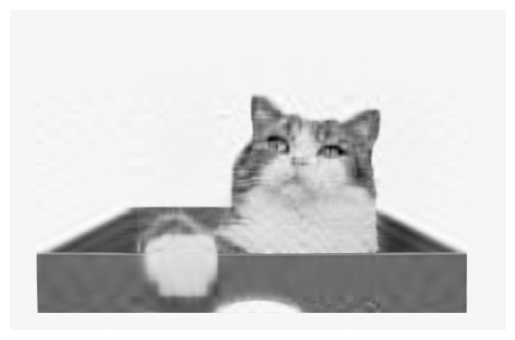

In [19]:
img_hat = le.forward(img)
show(img_hat)

This is a very different kind of reconstruction. The coarse features are very visible, but most of the detail is missing and the image is quite blurry. On the other hand, the cost of storing this representation of the image is very low. The original image required $263520$ floating point numbers to store. To store the compressed image, however, it is sufficient to store the encoded representation and the decoder weights. 

In [20]:
le.encoder(img).numel() + le.decoder.weight.numel()

21060

This is a very different kind of reconstruction: the coarse features are visible, but most of the detail is missing and the image is quite blurry. On the other hand, the cost of storing *this* representation is very, very low. 

## Note: Principal Component Analysis and SVD 

Throughout these notes, I've been referring to the "linear autoencoder" model for representing data in a lower dimensional space. In fact, this model has a rich history in statistics and data analysis: it is *Principal Component Analysis* (PCA). PCA is not usually solved with gradient descent methods, but rather with special linear algebra techniques that make use of its relationship to the *singular value decomposition (SVD)*. In addition to providing a much faster way to learn PCA than the gradient descent method that we've demonstrated here, SVD also makes it easy to use the singular values of the image in order to quantify the reconstruction loss. 

You can learn much more about PCA and its relationship with SVD in [these notes](https://www.cs.ox.ac.uk/people/james.worrell/SVD-thin.pdf) by James Worrell at Oxford.   
